In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

Brennweite: 1.0
Gegenstandsweite: 0.8 = 0.8 x f
Bildweite: -4.0
Gegenstandsgröße: 10.0
Bildgröße: 50.0, größer als Gegenstand


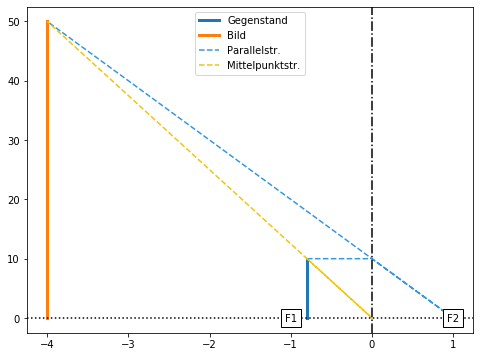

In [78]:
# Brennweite
f = 1
# Gegenstandsweite
g = 0.8
# Gegenstandsgröße
G = 10

# Bildweite (berechnet)
b = f*g/(g-f)
# Bildgröße (berechnet)
B = abs(b*G/g)

print('Brennweite: {:.1f}'.format(f))
print('Gegenstandsweite: {:.1f} = {:.1f} x f'.format(g, g/f))
print('Bildweite: {:.1f}'.format(b))
print('Gegenstandsgröße: {:.1f}'.format(G))
text_B = np.array(['kleiner', 'gleich groß', 'größer'])[np.array([B<G, B==G, B>G])][0]
print('Bildgröße: {:.1f}, {} als Gegenstand'.format(B, text_B))

# Gegenstand
plt.figure(figsize=[8,6])
plt.plot([-g,-g], [0,G], lw=3, label='Gegenstand')
sign = (1 if g<=f else -1)
# Bild
plt.plot([b,b], [0,sign*B], lw=3, label='Bild')
# Parallelstrahl
plt.plot([-g,0,f,b], [G,G,0,sign*B], color='#3498db', ls='--', label='Parallelstr.')
# Mittelpunktstrahl
plt.plot([-g,0,b], [G,0,sign*B], color='#f1c40f', ls='--', label='Mittelpunktstr.')
# Linsenebene, Optische Achse
plt.axhline(0, color='k', ls=':')
plt.axvline(0, color='k', ls='-.')
# Brennpunkte
boxstyle = dict(facecolor='white')
plt.text(-f,0,'F1', ha='center', va='center', bbox=boxstyle)
plt.text(f,0,'F2', ha='center', va='center', bbox=boxstyle)
# legend
plt.legend()

In [ ]:
np.repeat(-13, )

In [7]:
np.array(['kleiner', 'gleich', 'größer'])

array(['kleiner', 'gleich', 'größer'], dtype='<U7')

In [11]:
np.array(['kleiner', 'gleich', 'größer'])[np.array([B<G, B==G, B>G])][0]

'gleich'

In [119]:
def pop_random(lst):
    idx = random.randrange(0, len(lst))
    return lst.pop(idx)

def random_group_generator(names, group_size):
    pairs = []
    while names:
        pair = []
        for i in range(group_size):
            try:
                pair.append(pop_random(names))
            except ValueError:
                break
        pairs.append(pair)
    return pairs

In [133]:
names = """Augustin
Barion
Diaz Pfeifer
Egger
Felderer
Holzapfel
Kolbe
Kröss
Kurtaj
Leimstädtner
Masetti
Medina Abanto
Nutt
Pascotto
Perathoner
Prantner
Praxmarer
Rauter
Shehaj
Steiner
Wiedenhofer
Wierer"""

names = names.split('\n')
pairs = random_group_generator(names, group_size=4)
for i, pair in enumerate(pairs):
    print('- Gruppe {}: {}'.format(i+1, ', '.join(pair)))

- Gruppe 1: Wierer, Kurtaj, Augustin, Kolbe
- Gruppe 2: Nutt, Wiedenhofer, Pascotto, Perathoner
- Gruppe 3: Barion, Holzapfel, Masetti, Kröss
- Gruppe 4: Leimstädtner, Shehaj, Felderer, Diaz Pfeifer
- Gruppe 5: Prantner, Egger, Steiner, Praxmarer
- Gruppe 6: Medina Abanto, Rauter


['Herrmann', 'Goldner', 'Pilotti', 'Lenzi']

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# define glacier lenght and x values along flowline
L = 5e3 # im meters
x = np.arange(0, L)
# define constants
c0 = 1e7 # maximum positive mass balance (at glacier head)
c_m = 1 # 
m = 2 # mass balance exponent
# compute mass balance profile
mb = c0 - c_m * x**m

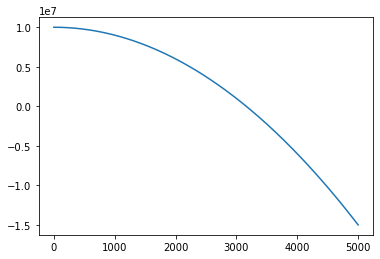

In [18]:
plt.plot(x, mb)

In [43]:
# necking
a = 5/6
k = x**a
# valley bottom
b = 3/5
bottom = x**b
# glacier surface
c = 1/2
surf = x**c

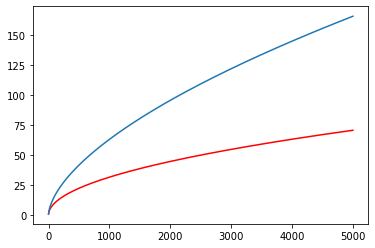

In [44]:
plt.plot(surf[1:], c='r')
plt.plot(bottom[1:])

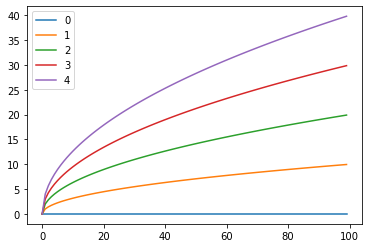

In [47]:
h = np.arange(0,100)
for k in range(0,5):
    w = k*np.sqrt(h)
    plt.plot(w, label=k)

plt.legend()

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


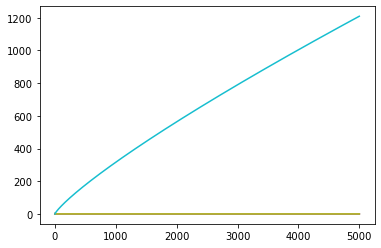

In [55]:
for a in np.arange(0.1, 1, 0.1):
    k = x**-a
    plt.plot(k, label=a)
    
plt.plot(x**(5/6))

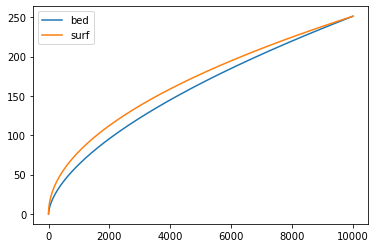

In [75]:
# dinstance up the valley
L = 10e3
x = np.arange(0,L) # 1km
# nekcing
a = 5/6
k = x**a
# valley bottom (bed rock)
b = 3/5
bed = x**b
plt.plot(x,bed, label='bed')
# glacier surface
c = 0.5
surf = L**(b-c)*x**c
plt.plot(x, surf, label='surf')
plt.legend()

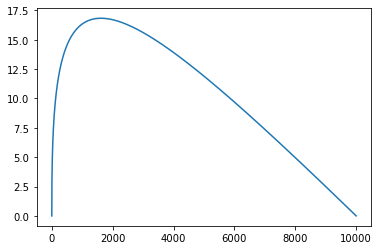

In [76]:
# compute ice thickness
h = surf-bed
plt.plot(x, h)

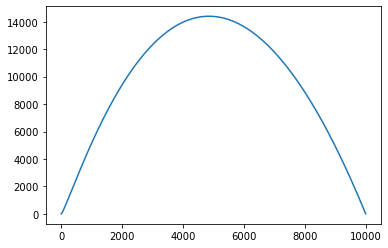

In [70]:
# compute width
w = k * h
plt.plot(x, w)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
t_solid = 0
t_liquid = 2

In [37]:
t[f == 0][0]

array([], dtype=float64)

No handles with labels found to put in legend.


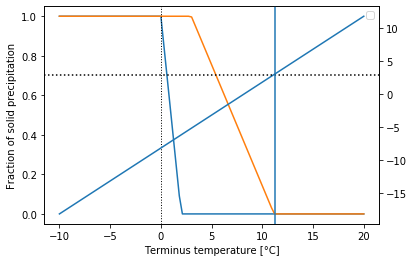

In [39]:
t_solid = 0
t_liquid = 2
t = np.linspace(-10,20,100)
f = 1 - (t-t_solid)/(t_liquid-t_solid)
f = np.clip(f, 0, 1)
plt.plot(t, f, label='fl')

t_solid = 3

grad_temp = -0.0065
h_min = 2430.0
h_max = 3685.0
f = 1 + (t-t_solid)/(grad_temp * (h_max - h_min))
f = np.clip(f, 0, 1)
plt.plot(t, f, label='vas')

plt.axvline(0, c='k', ls=':', lw=1)
#plt.axhline(0, c='k', ls=':', lw=1)
#plt.axhline(1, c='k', ls=':', lw=1)

plt.xlabel('Terminus temperature [°C]')
plt.ylabel('Fraction of solid precipitation')

plt.gca().twinx()
t_zmax = t + grad_temp * (h_max - h_min)
plt.plot(t, t_zmax)
plt.axhline(t_solid, c='k', ls=':')
plt.axvline(t[f == 0][0])

plt.legend()

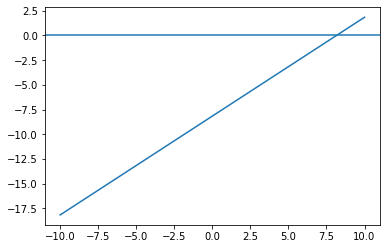

In [26]:
t_zmax = t + grad_temp * (h_max - h_min)
plt.plot(t, t_zmax)
plt.axhline(0)

In [15]:
import geopandas

ImportError: dlopen(/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/fiona/ogrext.cpython-36m-darwin.so, 2): Library not loaded: @rpath/libpoppler.71.dylib
  Referenced from: /Users/oberrauch/miniconda3/envs/oggm_env/lib/libgdal.20.dylib
  Reason: image not found

In [5]:
def inner(text='default'):
    print(text)
    


default
custom arg
costum kwarg


In [6]:
def invoce_inner(**kwargs):
    inner(**kwargs)

In [14]:
a = {'some': 'thing'}
a['some'] = None
a

{'some': None}

In [9]:
invoce_inner()
invoce_inner(text='costum kwarg')

default
costum kwarg


In [3]:
greet_me(some='thing')

some = thing


In [48]:
from oggm.tests import test_vascaling

import numpy as np
import datetime
import os
import shutil
import copy

# import test libs
import unittest
import pytest

# import gis libs
import geopandas as gpd

# import OGGM modules
import oggm
import oggm.cfg as cfg
from oggm import utils
from oggm.utils import (get_demo_file, ncDataset, md, rmsd_bc, rel_err,
                        corrcoef)
from oggm.core import (gis, vascaling, climate, centerlines,
                       massbalance, flowline, inversion)
from oggm.tests.funcs import get_test_dir, patch_url_retrieve_github

In [49]:
self = test_vascaling.TestVAScalingModel()

In [50]:
# test directory
self.testdir = os.path.join(get_test_dir(), 'tmp_vas')
if not os.path.exists(self.testdir):
    os.makedirs(self.testdir)
self.clean_dir()

# load default parametere file and set working directory
cfg.initialize()
cfg.PATHS['working_dir'] = self.testdir
# set path to GIS files
cfg.PARAMS['use_intersects'] = False
cfg.PATHS['dem_file'] = get_demo_file('hef_srtm.tif')
# set parameters for climate file and mass balance calibration
cfg.PARAMS['baseline_climate'] = 'CUSTOM'
cfg.PATHS['climate_file'] = get_demo_file('histalp_merged_hef.nc')
cfg.PARAMS['run_mb_calibration'] = True
# adjust parameters for HistAlp climate
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
cfg.PARAMS['temp_all_liq'] = 2.
cfg.PARAMS['temp_all_solid'] = 0.
cfg.PARAMS['temp_default_gradient'] = -0.0065

2019-07-03 12:48:25: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


2019-07-03 12:48:30: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-07-03 12:48:30: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-07-03 12:48:31: oggm.core.climate: (RGI50-11.00897) process_custom_climate_data
2019-07-03 12:48:31: oggm.core.vascaling: (RGI50-11.00897) local_t_star


2019-07-03 12:51:22: oggm.core.vascaling: (RGI50-11.00897) run_constant_climate
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 12:51:26: oggm.core.vascaling: (RGI50-11.00897) run_constant_climate_bias_p
/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")
2019-07-03 12:51:28: oggm.core.vascaling: (RGI50-11.00897) run_constant_climate_bias_n


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


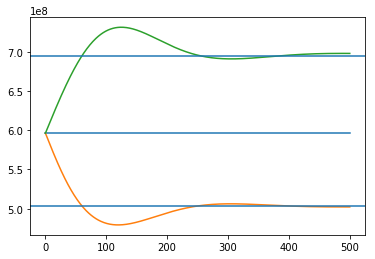

In [91]:
import matplotlib.pyplot as plt
plt.plot(ds.volume)
plt.plot(ds_p.volume)
avg_p = plt.axhline(ds_p.volume[ds_p.time > 300].mean())
plt.plot(ds_n.volume)
plt.axhline(ds_n.volume[ds_p.time > 300].mean())

In [87]:
ds.volume[ds_p.time > 300].mean()

<xarray.DataArray 'volume' ()>
array(5.962979e+08)

In [83]:
ds_p[]

KeyError: False

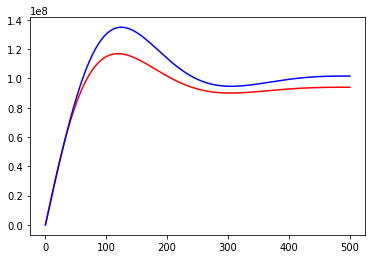

In [81]:
plt.plot(abs(ds_p - ds).volume, c='r')
plt.plot(abs(ds_n - ds).volume, c='b')

In [78]:
abs(ds_n - ds).volume

<xarray.DataArray 'volume' (time: 501, rgi_id: 1)>
array([[0.000000e+00],
       [1.887848e+06],
       [3.775236e+06],
       ...,
       [1.016047e+08],
       [1.016006e+08],
       [1.015962e+08]])
Coordinates:
  * rgi_id          (rgi_id) <U14 'RGI50-11.00897'
    calendar_month  (time) int64 10 10 10 10 10 10 10 10 10 10 10 10 10 10 ...
    calendar_year   (time) int64 -1 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
  * time            (time) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 ...
    hydro_year      (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...

In [61]:
assert abs(1 - ds.volume.mean() / ds.volume[0]) < 1e-7

<xarray.DataArray 'volume' (rgi_id: 1)>
array([ True])
Coordinates:
    time            float64 0.0
  * rgi_id          (rgi_id) <U14 'RGI50-11.00897'
    hydro_year      int64 0
    hydro_month     int64 1
    calendar_year   int64 -1
    calendar_month  int64 10

In [69]:
abs(ds_p.volume.mean() - ds_n.volume.mean()) 

<xarray.DataArray 'volume' ()>
array(1.936889e+08)

In [75]:
np.testing.assert_allclose(ds_p.volume.mean() - ds_n.volume.mean(), ds.volume.mean())

AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

(mismatch 100.0%)
 x: array(-1.936889e+08)
 y: array(5.962979e+08)

In [72]:
assert abs(ds_p.volume.mean() + ds_n.volume.mean()) < 1e-7 

AssertionError: 

In [128]:
# compute volume change from one year to the next
dV_p = (ds_p.volume[1:].values - ds_p.volume[:-1].values).flatten()
dV_n = (ds_n.volume[1:].values - ds_n.volume[:-1].values).flatten()
# compute relative volume change, with respect to the final volume
rate_p = abs(dV_p / float(ds_p.volume.values[-1]))
rate_n = abs(dV_n / float(ds_n.volume.values[-1]))
# the glacier should be in a new equilibirum for last 300 years
assert max(rate_p[-300:]) < 0.001
assert max(rate_n[-300:]) < 0.001

In [127]:

max(rate_n[-300:])

0.0005231155164758707

In [125]:
# compute volume change from one year to the next
dV_n = (ds_n.volume[1:].values - ds_n.volume[:-1].values).flatten()
# compute relative volume change, with respect to the final volume
rate_n = abs(dV_n / float(ds_n.volume.values[-1]))
max(rate_p[-300:]) < 0.001

In [94]:
eq_p = ds_p.volume[ds_p.time > 300].mean()
((ds_p.volume[ds_p.time > 300] - eq_p) / eq_p).mean()



<xarray.DataArray 'volume' ()>
array(3.425212e-16)

In [ ]:
eq_n = ds_n.volume[ds_p.time > 300].mean()

In [15]:
import numpy as np
from oggm.tests import test_models
from oggm.core.flowline import init_present_time_glacier
from oggm.core import massbalance
from oggm.core.flowline import FluxBasedModel

In [2]:
# create a TestCase object
self = test_models.TestHEF()

In [3]:
# initialize model and run prepro task
self.setUp()

2019-07-03 11:30:02: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-07-03 11:30:03: oggm.core.gis: (RGI50-11.00897) define_glacier_region
2019-07-03 11:30:03: oggm.workflow: Execute entity task glacier_masks on 1 glaciers
2019-07-03 11:30:03: oggm.workflow: Multiprocessing: using all available processors (N=4)
2019-07-03 11:30:03: oggm.core.gis: (RGI50-11.00897) glacier_masks
2019-07-03 11:30:04: oggm.workflow: Execute entity task compute_centerlines on 1 glaciers
2019-07-03 11:30:04: oggm.core.centerlines: (RGI50-11.00897) compute_centerlines
2019-07-03 11:30:05: oggm.core.centerlines: (RGI50-11.00897) initialize_flowlines
2019-07-03 11:30:05: oggm.core.centerlines: (RGI50-11.00897) compute_downstream_line
2019-07-03 11:30:06: oggm.core.centerlines: (RGI50-11.00897) compute_downstream_bedshape
2019-07-03 11:30:07: oggm.core.centerlines: (RGI50-11.00897) catchment_area
2019-07-03 11:30:09: oggm.core.centerlines: (RGI50-11.00897) catchment_intersecti

2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:14: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:15: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:15: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:15: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:15: oggm.core.inversion: (

2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (RGI50-11.00897) mass_conservation_inversion
2019-07-03 11:30:17: oggm.core.inversion: (

In [6]:
# merge data from preprocessing
init_present_time_glacier(self.gdir)

2019-07-03 11:31:33: oggm.core.flowline: (RGI50-11.00897) init_present_time_glacier


In [7]:
# create a massbalance model
mb_mod = massbalance.ConstantMassBalance(self.gdir)

In [23]:
# create a flowline model
SEC_IN_DAY = 24*3600
fls = self.gdir.read_pickle('model_flowlines')
model = FluxBasedModel(fls, mb_model=mb_mod, y0=0.,
                       fs=self.fs,
                       glen_a=self.glen_a,
                       min_dt=SEC_IN_DAY/2.,
                       mb_elev_feedback='never')

In [11]:
# store reference values for glacier geometries
ref_vol = model.volume_km3
ref_area = model.area_km2
ref_len = model.fls[-1].length_m

In [16]:
# compare model area with RGI value
np.testing.assert_allclose(ref_area, self.gdir.rgi_area_km2, rtol=0.03)

In [24]:
# def run_until_equilibrium(self, rate=0.001, ystep=5, max_ite=200):
rate = 1e-4
ystep = 5
max_ite = 200

# initialize the iteration counter, the close to zero counter
# and the 
ite = 0
was_close_zero = 0
t_rate = 1

In [32]:
model.mb_model

In [34]:
import oggm

In [42]:
model.mb_model.__class__ == oggm.core.massbalance.ConstantMassBalance

True

In [41]:
type()

oggm.utils._workflow.SuperclassMeta

In [38]:
isinstance(, )

False

In [25]:
# run until
while (t_rate > rate) and (ite <= max_ite) and (was_close_zero < 5):
    # increment the iteration counter
    ite += 1
    #  store current volume ('before')
    v_bef = model.volume_m3
    # run for a given number of years
    model.run_until(model.yr + ystep)
    # store new volume ('after')
    v_af = model.volume_m3
     
    if np.isclose(v_bef, 0., atol=1):
        # avoid division by zero
        t_rate = 1
        was_close_zero += 1
    else:
        # compute rate of volume change
        t_rate = np.abs(v_af - v_bef) / v_bef
    # user output
    print('v_bef:', v_bef)
    print('v_af:', v_af)
    print('t_rate:', t_rate)
    input('Press key to continue:')
# raise RuntimeError if maximum number of iterations is reached
if ite > max_ite:
    raise RuntimeError('Did not find equilibrium.')

v_bef: 573972416.8348739
v_af: 574231428.9505734
t_rate: 0.0004512623047773476
Press key to continue:1
v_bef: 574231428.9505734
v_af: 574866847.8755709
t_rate: 0.0011065554634630459
Press key to continue:1
v_bef: 574866847.8755709
v_af: 575589513.0640872
t_rate: 0.0012571001288157063
Press key to continue:
v_bef: 575589513.0640872
v_af: 576361674.11578
t_rate: 0.0013415134121925352
Press key to continue:
v_bef: 576361674.11578
v_af: 577176094.603664
t_rate: 0.0014130372029567725
Press key to continue:
v_bef: 577176094.603664
v_af: 577973510.8838334
t_rate: 0.0013815823067255385
Press key to continue:
v_bef: 577973510.8838334
v_af: 578723643.3614142
t_rate: 0.0012978665344605292
Press key to continue:
v_bef: 578723643.3614142
v_af: 579401541.2499331
t_rate: 0.0011713671910507737
Press key to continue:
v_bef: 579401541.2499331
v_af: 580007968.6074167
t_rate: 0.001046644363726389
Press key to continue:
v_bef: 580007968.6074167
v_af: 580549065.4034691
t_rate: 0.0009329126931678116
Press ke

KeyboardInterrupt: 

In [26]:
model.run_until_equilibrium(rate=1e-4)
self.assertFalse(model.dt_warning)
assert model.yr > 50
after_vol = model.volume_km3
after_area = model.area_km2
after_len = model.fls[-1].length_m

np.testing.assert_allclose(ref_vol, after_vol, rtol=0.1)
np.testing.assert_allclose(ref_area, after_area, rtol=0.03)
np.testing.assert_allclose(ref_len, after_len, atol=500.01)

In [10]:
from oggm.utils import ncDataset

In [23]:
# test
fpath = '/Users/oberrauch/OGGM/tests/6812c0f0a1d967e0725912a5602d4282e51cc617/tmp_prepro/RGI50-11/RGI50-11.00/RGI50-11.00897/gridded_data.nc'
grid_test = ncDataset(fpath)
grid_test

<class 'oggm.utils._workflow.ncDataset'>
root group (NETCDF4 data model, file format HDF5):
    author: OGGM
    author_info: Open Global Glacier Model
    proj_srs: +units=m +proj=tmerc +lat_0=0.0 +lon_0=10.7584 +k=0.9996 +x_0=0 +y_0=0 +datum=WGS84 
    max_h_dem: 3684.0
    min_h_dem: 2370.0
    max_h_glacier: 3684.0
    min_h_glacier: 2446.0
    dimensions(sizes): x(159), y(114)
    variables(dimensions): float32 x(x), float32 y(y), float32 topo(y,x), float32 topo_smoothed(y,x), int8 glacier_mask(y,x), int8 glacier_ext(y,x)
    groups: 

In [24]:
# mb calibration
fpath = '/Users/oberrauch/tmp/OGGM/OGGM_ref_mb_HISTALP_RGIV5/per_glacier/RGI50-11/RGI50-11.00/RGI50-11.00897/gridded_data.nc'
grid_calib = ncDataset(fpath)
grid_calib

<class 'oggm.utils._workflow.ncDataset'>
root group (NETCDF4 data model, file format HDF5):
    author: OGGM
    author_info: Open Global Glacier Model
    proj_srs: +units=m +proj=tmerc +lat_0=0.0 +lon_0=10.7584 +k=0.9996 +x_0=0 +y_0=0 +datum=WGS84 
    max_h_dem: 3685.0
    min_h_dem: 2369.0
    max_h_glacier: 3685.0
    min_h_glacier: 2430.0
    dimensions(sizes): x(159), y(114)
    variables(dimensions): float32 x(x), float32 y(y), float32 topo(y,x), float32 topo_smoothed(y,x), int8 glacier_mask(y,x), int8 glacier_ext(y,x)
    groups: 

In [26]:
(grid_calib.variables['glacier_mask'][:] == grid_test.variables['glacier_mask'][:]).all()

True

In [22]:
grid_calib.variables['topo'][:]

array([[2629., 2636., 2647., ..., 2589., 2577., 2566.],
       [2593., 2602., 2616., ..., 2572., 2559., 2546.],
       [2566., 2575., 2587., ..., 2553., 2537., 2520.],
       ...,
       [2949., 2955., 2961., ..., 3192., 3202., 3180.],
       [2979., 2986., 2990., ..., 3211., 3235., 3212.],
       [2994., 3011., 3025., ..., 3213., 3253., 3229.]], dtype=float32)

In [27]:
grid_test.variables['topo'][:]

array([[2596., 2596., 2610., ..., 2583., 2568., 2555.],
       [2565., 2569., 2582., ..., 2565., 2548., 2531.],
       [2539., 2547., 2557., ..., 2545., 2526., 2507.],
       ...,
       [2970., 2982., 2987., ..., 3180., 3226., 3227.],
       [2983., 3000., 3016., ..., 3177., 3238., 3246.],
       [2995., 3016., 3043., ..., 3176., 3247., 3263.]], dtype=float32)

In [25]:
(grid_calib.variables['topo'][:] == grid_test.variables['topo'][:]).all()

False

In [9]:
import pandas as pd
pd.read_csv('/Users/oberrauch/oggm-fork/oggm/data/ref_tstars_vas_rgi5_histalp.csv')

,Unnamed: 0,lon,lat,n_mb_years,tstar,bias
0,RGI50-11.00002,13.613500,47.484500,8,1911,25.030687
1,RGI50-11.00012,13.058100,47.424200,10,1967,1.894659
2,RGI50-11.00073,12.595600,47.140300,17,1983,6.710049
3,RGI50-11.00080,12.596400,47.131600,63,1932,2.570614
4,RGI50-11.00106,12.696700,47.099100,28,1890,-12.909590
5,RGI50-11.00190,12.378400,47.085100,8,1867,1.599925
6,RGI50-11.00251,12.947200,47.053000,16,1980,14.303069
7,RGI50-11.00289,12.970200,47.042100,26,1882,-0.175383
8,RGI50-11.00300,13.004900,47.038500,32,1917,0.670287
9,RGI50-11.00603,11.224700,46.965600,19,1911,382.336042


In [1]:
import xarray as xr

In [7]:
import oggm

In [10]:
oggm.__path__[0]

'/Users/oberrauch/oggm-fork/oggm'

In [21]:
a = {'rgi_id': 'RGI50-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 47.7647032029939}
b = {'rgi_id': 'RGI50-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 47.7647032029939}
c = {'rgi_id': 'RGI50-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 47.7647032029939}

In [22]:
assert a == b
assert b == c

In [24]:
a['t_star']

'RGI50-11.00897'

In [11]:
import os

In [14]:
ref_df_path = os.path.join(oggm.__path__[0], 'data',
                                   'ref_tstars_vas_rgi5_histalp.csv')
os.path.isfile(ref_df_path)

True

In [4]:
ds = xr.Dataset()
ds

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [7]:
# RGI60, HISTALP
{'rgi_id': 'RGI60-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 48.981949777713275}
# RGI50, HISTALP
{'rgi_id': 'RGI50-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 48.981949777713275}
# from REF MB, RGI50, HISTALP
{'rgi_id': 'RGI50-11.00897', 't_star': 1905, 'bias': 66.12871878745477, 'mu_star': 47.7647032029939}

# RGI60, CRU
{'rgi_id': 'RGI60-11.00897', 't_star': 1923, 'bias': -1.3285208637198591, 'mu_star': 90.92372668199351}
# RGI50, CRU
{'rgi_id': 'RGI50-11.00897', 't_star': 1923, 'bias': -1.3285208637198591, 'mu_star': 90.92372668199351}

{'rgi_id': 'RGI60-11.00897',
 't_star': 1927,
 'bias': 1.8174709620680003,
 'mu_star': 46.01145880923103}

In [3]:
import os
from oggm.tests.funcs import get_test_dir
os.path.join(get_test_dir(), 'tmp_prepro')

'/Users/oberrauch/OGGM/tests/6812c0f0a1d967e0725912a5602d4282e51cc617/tmp_prepro'

In [6]:
ll /Users/oberrauch/OGGM/tests/6812c0f0a1d967e0725912a5602d4282e51cc617/

total 0
drwxr-xr-x  3 oberrauch  staff  102 May  5 17:24 start_area/
drwxr-xr-x  3 oberrauch  staff  102 May  3 17:37 tmp_ben/
drwxr-xr-x  3 oberrauch  staff  102 May  5 17:35 tmp_comparison/


In [5]:
# import externals libs
import os
import shutil
from scipy.io import  loadmat
import matplotlib.pyplot as plt
# import the needed OGGM modules
import oggm
from oggm import cfg, utils
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, vascaling

# create test directory
testdir = os.path.join(get_test_dir(), 'start_area')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

# load default parameter file
cfg.initialize()
# set path to working directory
cfg.PATHS['working_dir'] = testdir
# load and set path to intersects
path = utils.get_rgi_intersects_region_file('11', version='6')
cfg.set_intersects_db(path)

# change some default parameters
cfg.PARAMS['border'] = 50
cfg.PARAMS['baseline_climate'] = 'CRU'
cfg.PARAMS['use_multiprocessing'] = True

# get RGI entity
rgi_id = 'RGI60-11.00897'
entity = utils.get_rgi_glacier_entities([rgi_id]).iloc[0]

# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)

# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

# process the given climate file
climate.process_cru_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

# --------------------
#  MASS BALANCE TASKS
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
# instance the mass balance models
mbmod = vascaling.VAScalingMassBalance(gdir)

# ----------------
#  DYNAMICAL PART
# ----------------
# get reference area
a0 = gdir.rgi_area_m2
# get reference year
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

2019-05-05 17:24:56: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg
2019-05-05 17:24:57: oggm.core.gis: (RGI60-11.00897) define_glacier_region
2019-05-05 17:24:57: oggm.core.gis: (RGI60-11.00897) glacier_masks
2019-05-05 17:24:58: oggm.core.climate: (RGI60-11.00897) process_cru_data
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) compute_centerlines
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) initialize_flowlines
2019-05-05 17:25:03: oggm.core.centerlines: (RGI60-11.00897) catchment_area
2019-05-05 17:25:05: oggm.core.centerlines: (RGI60-11.00897) catchment_intersections
2019-05-05 17:25:05: oggm.core.centerlines: (RGI60-11.00897) catchment_width_geom
2019-05-05 17:25:06: oggm.core.centerlines: (RGI60-11.00897) catchment_width_correction


In [6]:
# initialize counter variable
k = 2
# specify path to *.mat file and see if file exists
mat_file = '../data/start_area_results/{:s}_iteration_{:02d}.mat'.format(rgi_id, k)
# read mat file
mat_file = loadmat(mat_file)

In [7]:
ben_model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=mbmod)

# init model with best guess start area
area_m2_start = mat_file['A_pre'][0,0] * 1e6
ben_model.create_start_glacier(area_m2_start, year_start=1902)
diag_ds = ben_model.run_until_and_store(2003)

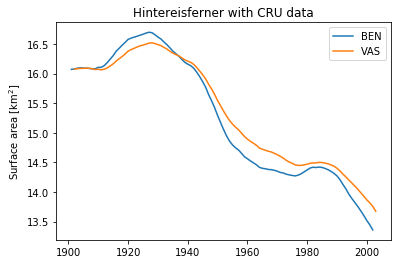

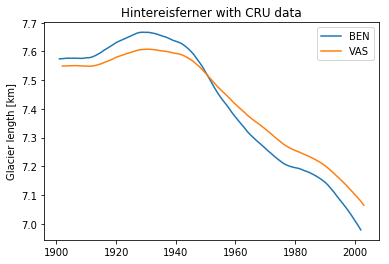

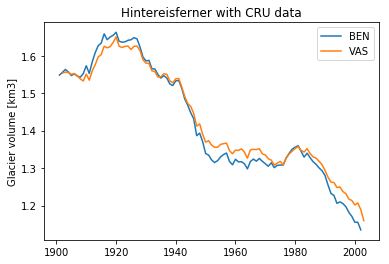

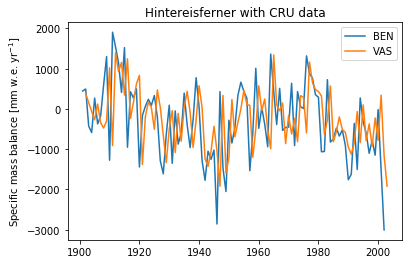

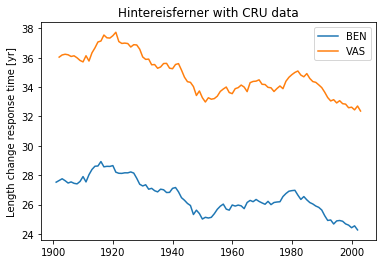

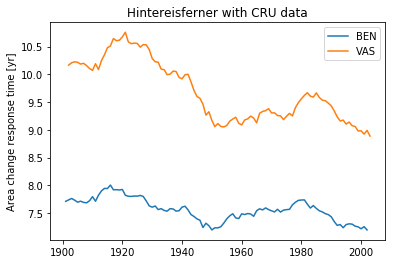

In [8]:
# prepare parameters for plotting
mat_years = mat_file['years'][0, :102]
vas_years = diag_ds.hydro_year
mat_params = ['A_pre', 'L_pre', 'V_pre', 'mb_modeled_pre', 'tau_L', 'tau_A']
vas_params = ['area_m2', 'length_m', 'volume_m3', 'spec_mb', 'tau_l', 'tau_a']
labels = ['Surface area [km$^2$]', 'Glacier length [km]',
          'Glacier volume [km3]', 'Specific mass balance [mm w.e. yr$^{-1}$]',
          'Length change response time [yr]', 'Area change response time [yr]']
factors = [1e6, 1e3, 1e9, 1, 1, 1]
# plot all parameters
for mat, vas, label, f in zip(mat_params, vas_params, labels, factors):
    plt.figure()
    plt.plot(mat_years, mat_file[mat][0, :102], label='BEN')
    plt.plot(vas_years, diag_ds[vas] / f, label='VAS')
    plt.legend()
    plt.xlabel('')
    plt.ylabel(label)
    plt.title('Hintereisferner with CRU data')

In [26]:
diag_ds_full = diag_ds.copy()

In [30]:
diag_ds = diag_ds_full.sel(time=slice(1902,1912))

In [28]:
import matplotlib.pyplot as plt

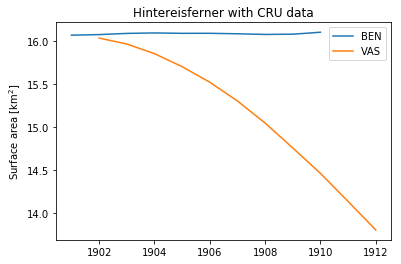

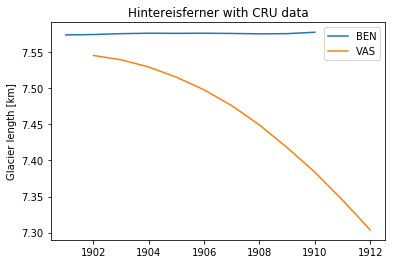

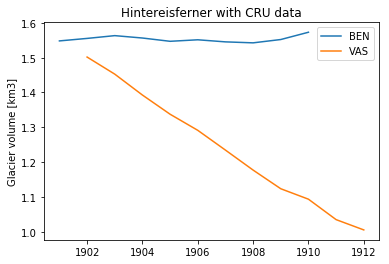

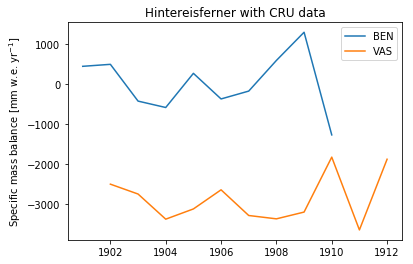

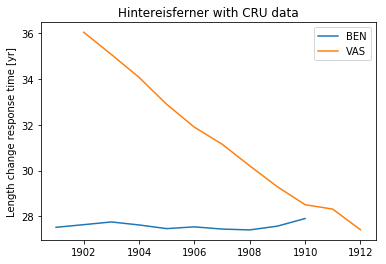

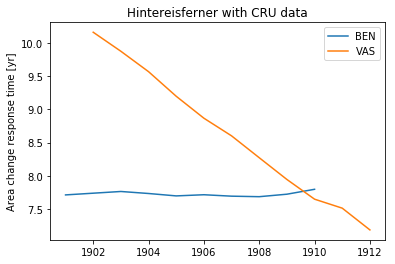

In [31]:
# prepare parameters for plotting
mat_years = mat_file['years'][0, :10]
vas_years = diag_ds.hydro_year
mat_params = ['A_pre', 'L_pre', 'V_pre', 'mb_modeled_pre', 'tau_L', 'tau_A']
vas_params = ['area_m2', 'length_m', 'volume_m3', 'spec_mb', 'tau_l', 'tau_a']
labels = ['Surface area [km$^2$]', 'Glacier length [km]',
          'Glacier volume [km3]', 'Specific mass balance [mm w.e. yr$^{-1}$]',
          'Length change response time [yr]', 'Area change response time [yr]']
factors = [1e6, 1e3, 1e9, 1, 1, 1]
# plot all parameters
for mat, vas, label, f in zip(mat_params, vas_params, labels, factors):
    plt.figure()
    plt.plot(mat_years, mat_file[mat][0, :10], label='BEN')
    plt.plot(vas_years, diag_ds[vas] / f, label='VAS')
    plt.legend()
    plt.xlabel('')
    plt.ylabel(label)
    plt.title('Hintereisferner with CRU data')

In [ ]:
# import externals libs
import os
import shutil
import scipy.io
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# import the needed OGGM modules
import oggm
from oggm import cfg, utils
from oggm.utils import get_demo_file
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines, vascaling

In [ ]:
# create test directory
testdir = os.path.join(get_test_dir(), 'tmp_ben')
if not os.path.exists(testdir):
    os.makedirs(testdir)
shutil.rmtree(testdir)
os.makedirs(testdir)

In [ ]:
# load default parameter file
cfg.initialize()
# set path to working directory
cfg.PATHS['working_dir'] = testdir
# load and set path to intersects
path = utils.get_rgi_intersects_region_file('11', version='6')
cfg.set_intersects_db(path)

# change some default parameters
cfg.PARAMS['border'] = 50
cfg.PARAMS['baseline_climate'] = 'CRU'
cfg.PARAMS['use_multiprocessing'] = True


In [ ]:
utils.get_rgi_glacier_entities(['RGI60-11.00897'])

In [ ]:
# get RGI entity
entity = utils.get_rgi_glacier_entities(['RGI60-11.00897']).iloc[0]
# initialize the GlacierDirectory
gdir = oggm.GlacierDirectory(entity, base_dir=testdir)
# define the local grid and glacier mask
gis.define_glacier_region(gdir, entity=entity)
gis.glacier_masks(gdir)

In [ ]:
# process the given climate file
climate.process_cru_data(gdir)

# run center line preprocessing tasks
centerlines.compute_centerlines(gdir)
centerlines.initialize_flowlines(gdir)
centerlines.catchment_area(gdir)
centerlines.catchment_intersections(gdir)
centerlines.catchment_width_geom(gdir)
centerlines.catchment_width_correction(gdir)

In [ ]:
# --------------------
#  MASS BALANCE TASKS
# --------------------

# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)

# instance the mass balance models
mbmod = vascaling.VAScalingMassBalance(gdir)

In [ ]:
# ----------------
#  DYNAMICAL PART
# ----------------
# get reference area
a0 = gdir.rgi_area_m2
# get reference year
y0 = gdir.read_pickle('climate_info')['baseline_hydro_yr_0']
# get min and max glacier surface elevation
h0, h1 = vascaling.get_min_max_elevation(gdir)

ben_model = vascaling.VAScalingModel(year_0=y0, area_m2_0=a0,
                                     min_hgt=h0, max_hgt=h1,
                                     mb_model=mbmod)

In [ ]:
ben_model.create_start_glacier(9.793874999999998*1e6, year_start=1902)
diag_ds = ben_model.run_until_and_store(2003)

In [ ]:
diag_ds.area_m2.plot()

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/full_workspace.mat')

# get needed parameters from *.mat file
years = np.array([yr for yr in mat['cru_years']])
years = years[years <= 2003]
a_pre = np.array([a for a in mat['A_pre']])[0]
a_ben = a_pre.copy()

In [ ]:
diag_ds

In [ ]:
# plot both modeled area changes
plt.plot(years, a_ben, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.area_m2/1e6, label='VAS')
plt.legend()
plt.xlabel('')
plt.ylabel('Surface area [km$^2$]')
plt.title('Hintereisferner with CRU data, A$_0$ = {:.2f} km$^2$'.format(a_ben[0]))

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/A_pre_best_guess.mat')
years = np.arange(1901, 2004)
# get area
a_best_fit = np.array([a for a in mat['A_pre']])[0]
a_ben = a_best_fit.copy()

plt.plot(years, a_best_fit, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.area_m2/1e6, label='VAS')
plt.legend()
plt.xlabel('')
plt.ylabel('Surface area [km$^2$]')
plt.title('Hintereisferner with CRU data, A$_0$ = {:.2f} km$^2$'.format(a_ben[0]))

In [ ]:
# read matlab data
mat = scipy.io.loadmat('/Users/oberrauch/work/master/data/mat_files/time_scales.mat')
# get time scales
tau_l = np.array([a for a in mat['tau_L']])[0]
tau_a = np.array([a for a in mat['tau_A']])[0]

In [ ]:
plt.plot(years[1:], tau_l, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.tau_l, label='VAS')
plt.legend()

In [ ]:
diag_ds.tau_a

In [ ]:
plt.plot(years[1:], tau_a, label='BEN')
plt.plot(diag_ds.hydro_year, diag_ds.tau_a, label='VAS')
plt.legend()

In [ ]:
ben_model.create_start_glacier(16.072e6, year_start=1902)
print(ben_model)

In [ ]:
i = 0
print('Iteration', i, '\n-----------------')
print('Area {:.3f} km2'.format(diag_ds.area_m2[i].values/1e6))
print('Volume {:.3f} km3'.format(diag_ds.volume_m3[i].values/1e9))
print('Length {:.3f} km'.format(diag_ds.length_m[i].values/1e3))

In [ ]:
diag_ds

In [ ]:
df = diag_ds.to_dataframe()
df = pd.concat([df['length_m'], df['area_m2'], df['volume_m3']], axis=1)

In [ ]:
store = False
if store:
    # define path and file names
    folder = '/Users/oberrauch/work/master/data/'
    suffix = '_test_start_area'
    names = ['length', 'area', 'volume']
    # combine glacier geometries into DataFrame
    import numpy as np
    import pandas as pd
    df = [diag_ds['hydro_year', 'length_m'], diag_ds['area_m2'], diag_ds['volume_m3']]
    df = pd.concat([df_.to_dataframe() for df_ in df])
    df.to_csv(folder+'run'+suffix+'.csv')

plot = True
if plot:
    unit = 'km'
    unit_factor = 1e3
    # define path and file names
    folder = '/Users/oberrauch/work/master/plots/'
    suffix = '_test_start_area'

    plt.figure()
    plt.plot(diag_ds['area_m2']/unit_factor**2)
    plt.title('Hintereis Ferner - Area')
    plt.ylabel('Area [{}$^2$]'.format(unit))
    plt.savefig(folder+'area'+suffix+'.png', bbox_inches='tight')

    plt.figure()
    plt.plot(diag_ds['volume_m3']/unit_factor**3)
    plt.title('Hintereis Ferner - Volume')
    plt.ylabel('Volume [{}$^3$]'.format(unit))
    plt.savefig(folder+'volume'+suffix+'.png', bbox_inches='tight')

    plt.figure()
    plt.plot(diag_ds['length_m']/unit_factor)
    plt.title('Hintereis Ferner - Length')
    plt.ylabel('Length [{}]'.format(unit))
    plt.savefig(folder+'length'+suffix+'.png', bbox_inches='tight')

    plt.show()

In [ ]:
df.iloc[-1]